# HW10 - Assignment 1 - Complete Spatial Data Analysis for Summer & Winter Months
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

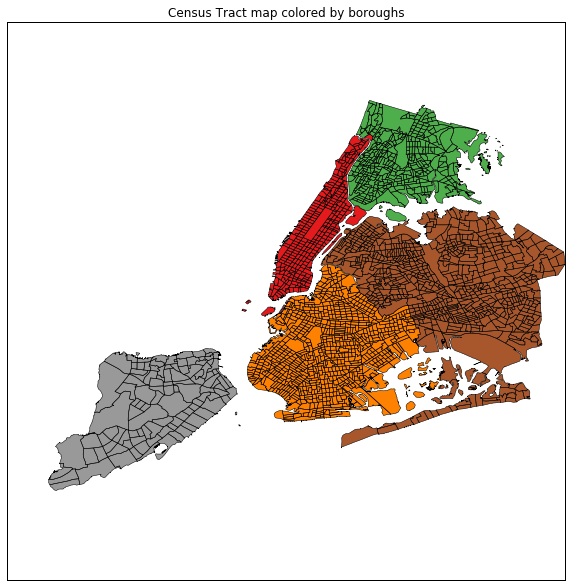

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


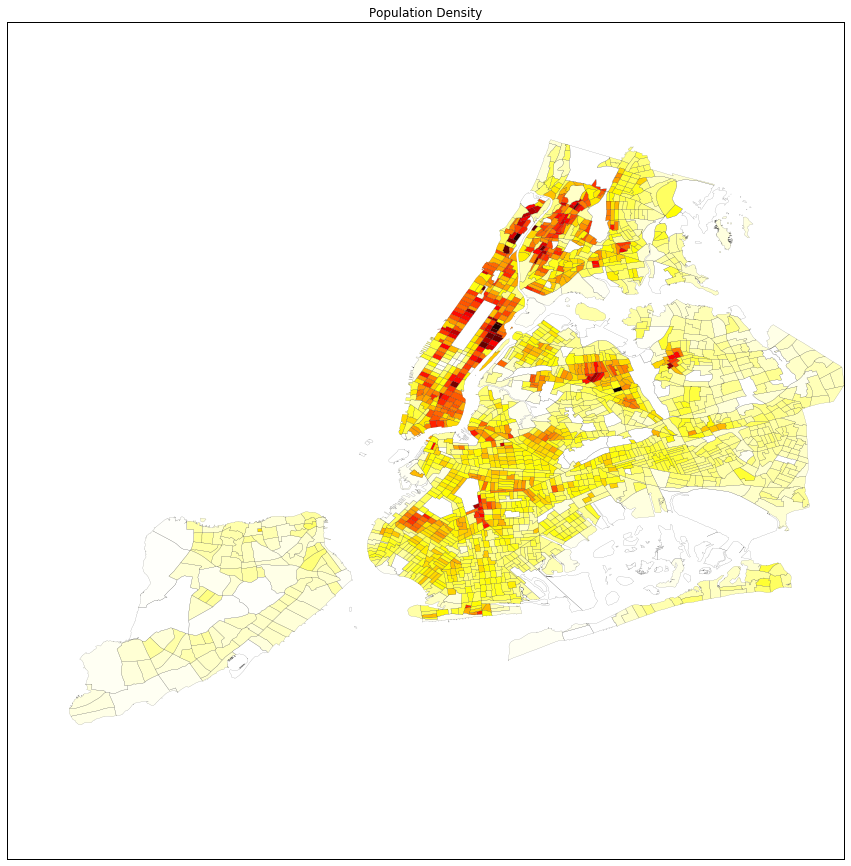

In [8]:
f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

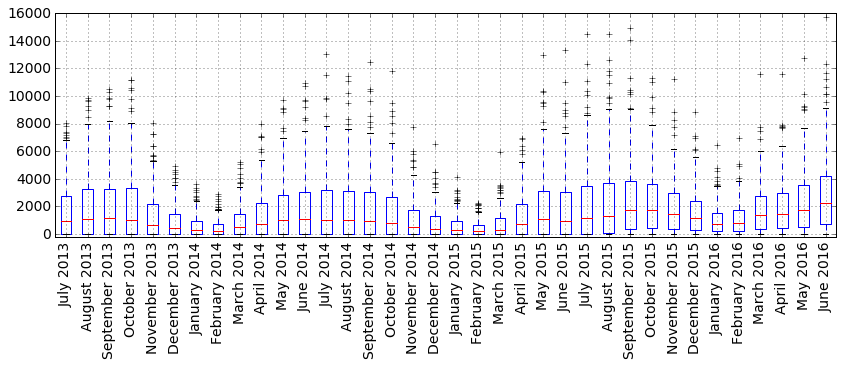

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


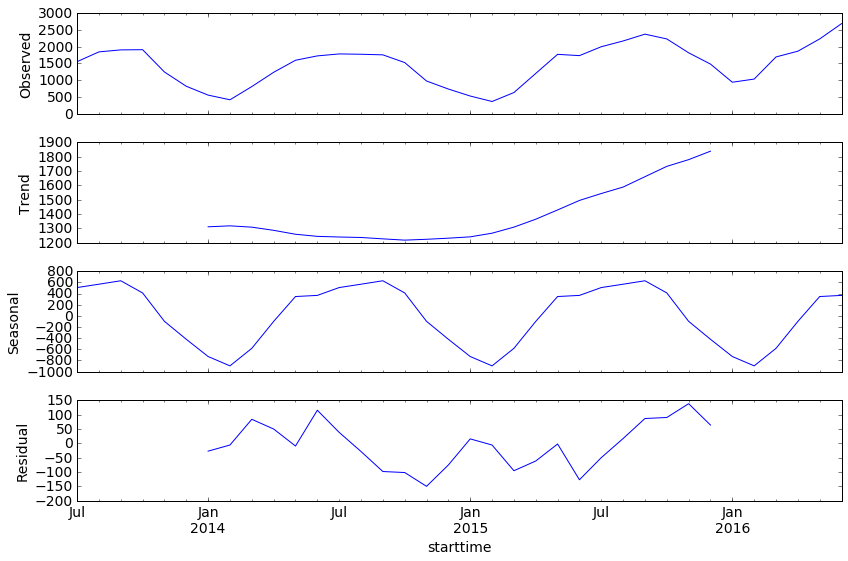

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [23]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [24]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [25]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [26]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Split the dataframe into Summer & Winter months

In [27]:
df_summer = df_bike_monthly[(df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month >= 6)]
df_winter = df_bike_monthly[(df_bike_monthly.index.month <= 3) | (df_bike_monthly.index.month == 12)]

### Add Monthly rides for Summer & Winter months to the station GeoDataFrame with CT code

In [44]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['WinterAvg']=df_winter.mean()
station_id['SummerAvg']=df_summer.mean()

In [45]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAvg,SummerAvg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1342.750000,3830.500000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000


### Add the Summer & Winter monthly averages rides to the CT shapefile 

In [50]:
temp=station_id[['WinterAvg']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_WinterAvg=ct_shape.join(temp)#join the temp dataframe to the shape file
ct_shape_WinterAvg.fillna(0,inplace=True)

temp2=station_id[['SummerAvg']]
temp2['station_id']=station_id.index
temp2.index=station_id['BoroCT2010']#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_SummerAvg=ct_shape.join(temp2)#join the temp dataframe to the shape file
ct_shape_SummerAvg.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


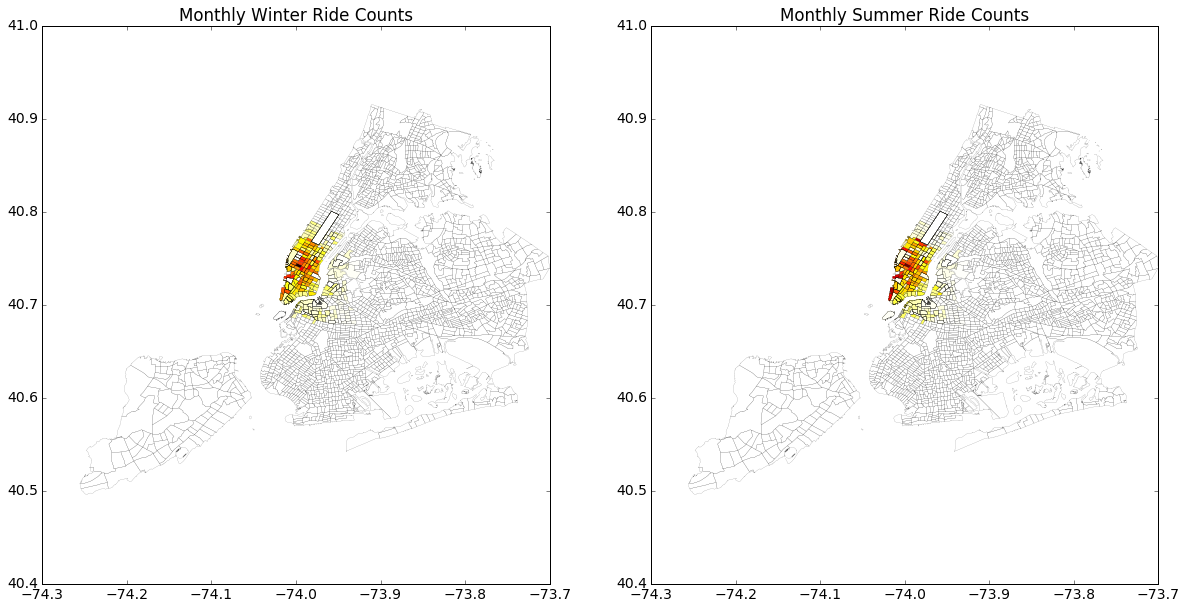

In [51]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ct_shape_WinterAvg.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Monthly Winter Ride Counts")
ax2 = plt.subplot(122)
ct_shape_SummerAvg.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Monthly Summer Ride Counts")

### Removing the CTs that are out of zoom boundries

In [53]:
ct_shape_WinterAvg_Zoom=(ct_shape_WinterAvg[ct_shape_WinterAvg
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])
#centroid, give it a boundary, the lat and long are the boundaries, everything beyond it is false, everything within is true

ct_shape_SummerAvg_Zoom=(ct_shape_SummerAvg[ct_shape_SummerAvg
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [54]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs (Winter):", len(temp.WinterAvg)
print "Number of zoomed CTs (Summer):", len(temp2.SummerAvg)

Total number of CTs: 2166
Number of zoomed CTs (Winter): 543
Number of zoomed CTs (Summer): 543


### Map the monthly rides 

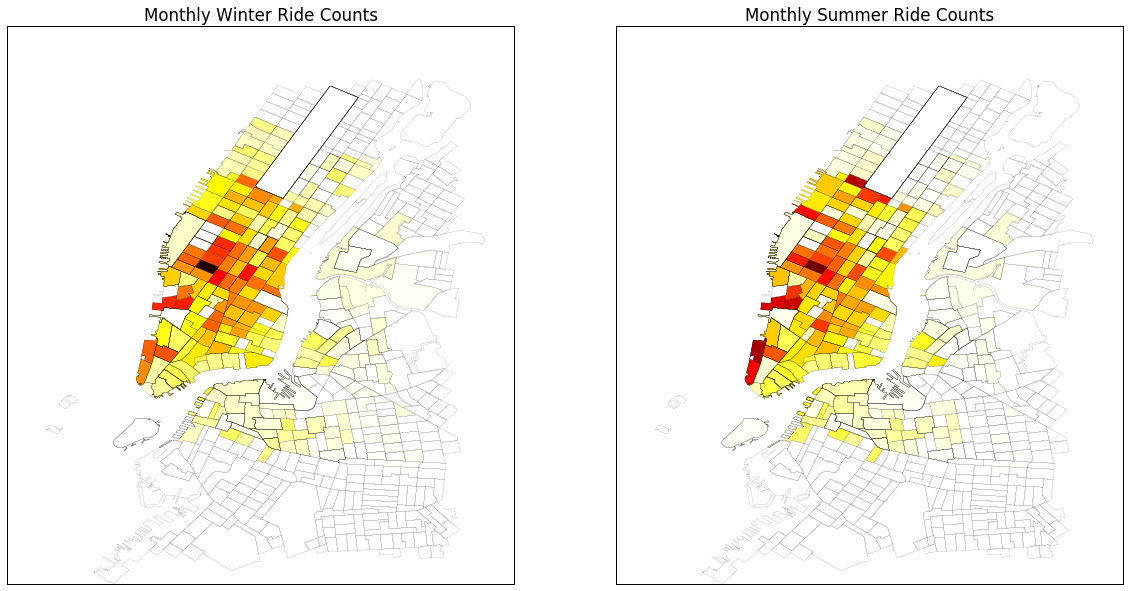

In [55]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ct_shape_WinterAvg_Zoom.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Monthly Winter Ride Counts")

ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_SummerAvg_Zoom.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Monthly Summer Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [56]:
path='Output/ct_shape_WinterAvg_Zoom.shp'
ct_shape_WinterAvg_Zoom.to_file(path)

path='Output/ct_shape_SummerAvg_Zoom.shp'
ct_shape_SummerAvg_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [57]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [58]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [59]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [60]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [61]:
Wmatrix, ids = qW_CT.full()

In [62]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [63]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [65]:
WinterRide=ct_shape_WinterAvg_Zoom.WinterAvg
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)
#give the lag of monthly rider ship, input the weighted

SummerRide=ct_shape_SummerAvg_Zoom.SummerAvg
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)
#give the lag of monthly rider ship, input the weighted

#### Create Quantiles for maping

In [66]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print "Winter Ride Lag", WinterRideLagQ10
#by having a bin for less than 0, you take out the values that are less than 0

SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print "Summer Ride Lag", SummerRideLagQ10
#by having a bin for less than 0, you take out the values that are less than 0

Winter Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    4.595                 2
   4.595 < x[i] <=   75.189                78
  75.189 < x[i] <=  180.444                80
 180.444 < x[i] <=  287.743                79
 287.743 < x[i] <=  417.840                80
 417.840 < x[i] <=  937.426                79
 937.426 < x[i] <= 1267.157                80
1267.157 < x[i] <= 1539.785                79
1539.785 < x[i] <= 2491.899                80
Summer Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    7.333                 2
   7.333 < x[i] <=  125.969                78
 125.969 < x[i] <=  256.250                80
 256.250 < x[i] <=  629.283                81
 629.283 < x[i] <=  968.988                78
 968.988 < x[i] <= 2141.150                7

#### Map the monthly rides lag

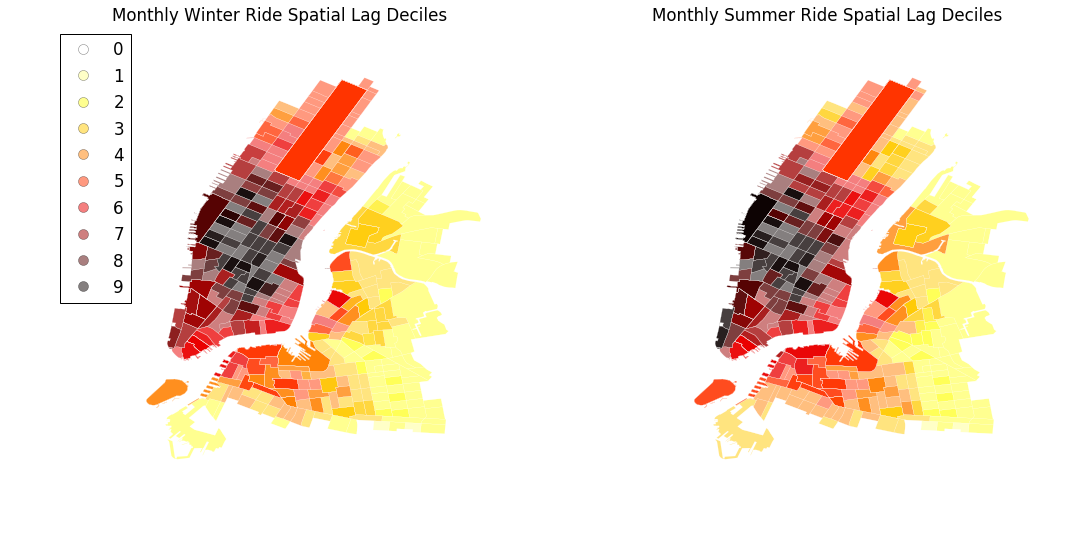

In [67]:
f, ax = plt.subplots(figsize=(18, 9))
ax1 = plt.subplot(121)
ct_shape_WinterAvg_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Monthly Winter Ride Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_SummerAvg_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=False)
ax2.set_axis_off()
plt.title("Monthly Summer Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [68]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
print "Slope (Winter) = ", b, "Y-intercept: ", a 
#slope and intercept of a line (linear bc input = 1)

b2,a2 = np.polyfit(SummerRide, SummerRideLag, 1)
print "Slope (Summer) = ", b2, "Y-intercept: ", a2 

Slope (Winter) =  0.661894622507 Y-intercept:  194.318136773
Slope (Summer) =  0.643893143126 Y-intercept:  473.577589895


### Moran Scatterplot

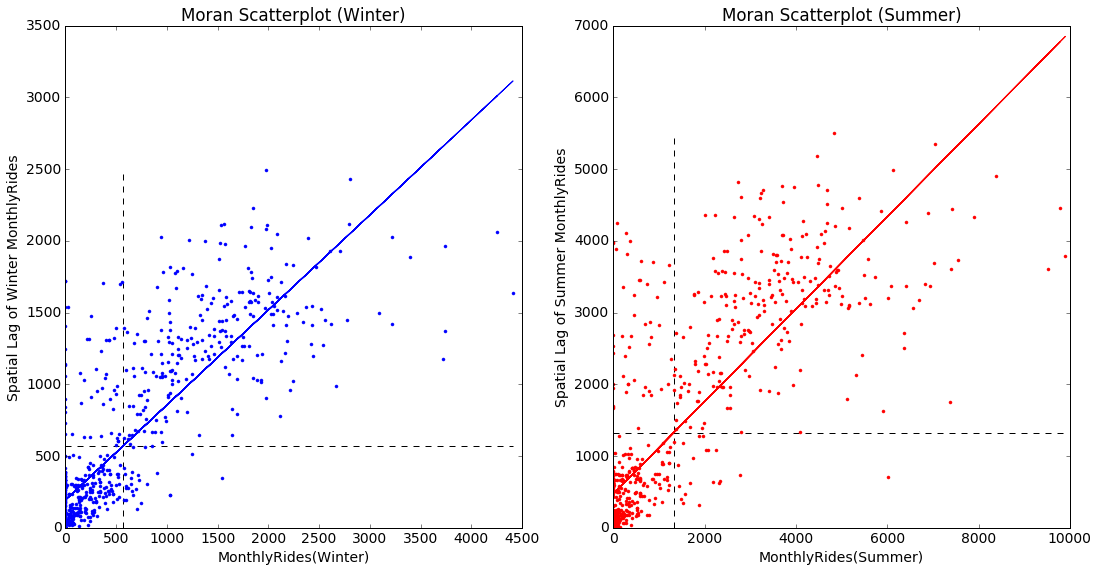

In [74]:
f, ax = plt.subplots(1, figsize=(18, 9))

ax1 = plt.subplot(121)
plt.plot(WinterRide, WinterRideLag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'blue')
plt.title('Moran Scatterplot (Winter)')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('MonthlyRides(Winter)')

ax2 = plt.subplot(122)
plt.plot(SummerRide, SummerRideLag, '.', color='red')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'red')
plt.title('Moran Scatterplot (Summer)')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('MonthlyRides(Summer)')

### Moran's I

In [75]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [76]:
print "Winter", I_WinterRide.I, I_WinterRide.p_sim
print "Summer", I_SummerRide.I, I_SummerRide.p_sim
#same as .65 as before
#0.001 is the p value --> how significant
# only .1% that this would happen randomly

Winter 0.662044196711 0.001
Summer 0.644069499068 0.001


Thus, the $I$ statistic is $0.662$ for the Winter data, and has a very small $p$ value. 
<br>
Also, the $I$ statistic is $0.644$ for the Summer data, and has a very small $p$ value. 

In [77]:
print "Winter", I_WinterRide.sim[0:10]
print "Summer", I_SummerRide.sim[0:10]

Winter [-0.0291325   0.01653631  0.00432219 -0.00636249 -0.02618358 -0.02335434
  0.00152486  0.03387956 -0.00321182  0.00266151]
Summer [ 0.01258038  0.04125939 -0.02358774 -0.00361519 -0.02260017  0.00386397
 -0.00359637 -0.01527487 -0.01574719 -0.0123085 ]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [79]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,6)

(-0.7, 0.7)

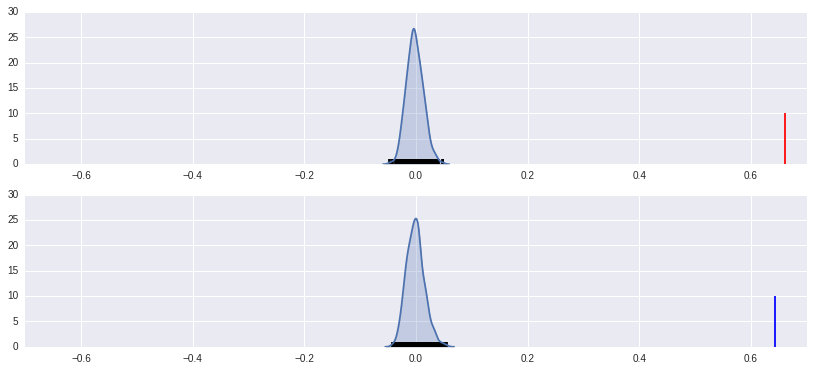

In [80]:
ax1 = plt.subplot(211)
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

ax2 = plt.subplot(212)
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'b')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

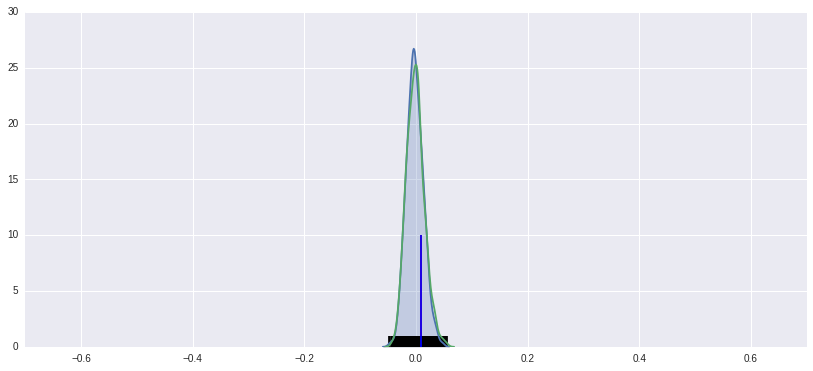

In [81]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
sns.kdeplot(I_SummerRide.sim, shade=False)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'b')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [82]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
print "Winter", LMo_WinterRide
print "Summer", LMo_SummerRide

Winter <pysal.esda.moran.Moran_Local object at 0x7fcf14c8f890>
Summer <pysal.esda.moran.Moran_Local object at 0x7fcf14c25310>


In [83]:
print "Winter", LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]
print "Summer", LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

Winter [-0.         -0.3153042  -0.00110645 -0.00100209 -0.06082761] [ 0.001  0.14   0.483  0.5    0.414]
Summer [-0.         -0.23689404  0.01179723  0.00235718  0.0247348 ] [ 0.001  0.194  0.36   0.352  0.392]


### LISA (Local Indicators of Spatial Autocorrelation)

In [84]:
Wsigs = WinterRide[LMo_WinterRide.p_sim <= .001]
WW_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
Winsigs = WinterRide[LMo_WinterRide.p_sim > .001]
WW_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

Ssigs = SummerRide[LMo_SummerRide.p_sim <= .001]
SW_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
Sinsigs = SummerRide[LMo_SummerRide.p_sim > .001]
SW_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

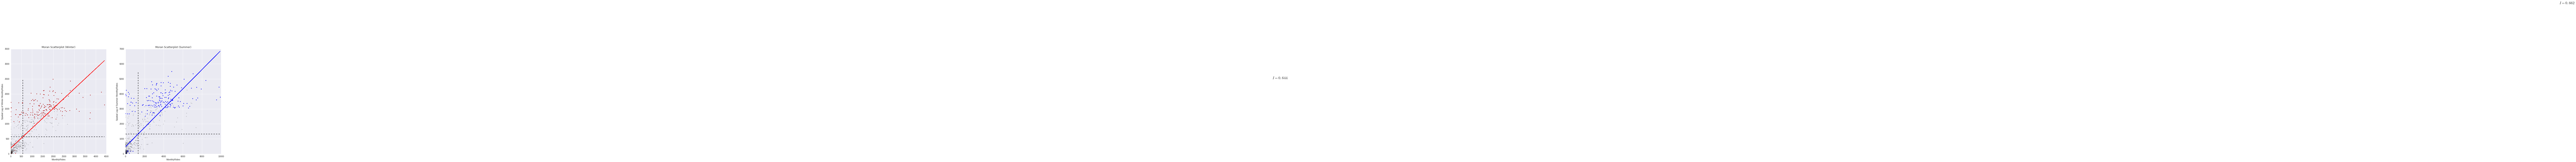

In [94]:
f, ax = plt.subplots(figsize=(18, 9))

ax1 = plt.subplot(121)
plt.plot(Wsigs, WW_sigs, '.', color='firebrick')
plt.plot(Winsigs, WW_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot (Winter)')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('MonthlyRides')

ax2 = plt.subplot(122)
plt.plot(Ssigs, SW_sigs, '.', color='blue')
plt.plot(Sinsigs, SW_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'b')
plt.title('Moran Scatterplot (Summer)')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('MonthlyRides')

### Hot and Cold spots 

In [95]:
Wsig = LMo_WinterRide.p_sim < 0.01
#boundary of signficants
w_hotspots = LMo_WinterRide.q==1 * Wsig
w_coldspots = LMo_WinterRide.q==3 * Wsig
print "Number of Hotspots (Winter):", w_hotspots.sum()
print "Number of Coldspots (Winter):", w_coldspots.sum()

Ssig = LMo_SummerRide.p_sim < 0.01
#boundary of signficants
s_hotspots = LMo_SummerRide.q==1 * Ssig
s_coldspots = LMo_SummerRide.q==3 * Ssig
print "Number of Hotspots (Summer):", s_hotspots.sum()
print "Number of Coldspots (Summer):", s_coldspots.sum()

Number of Hotspots (Winter): 198
Number of Coldspots (Winter): 207
Number of Hotspots (Summer): 188
Number of Coldspots (Summer): 239


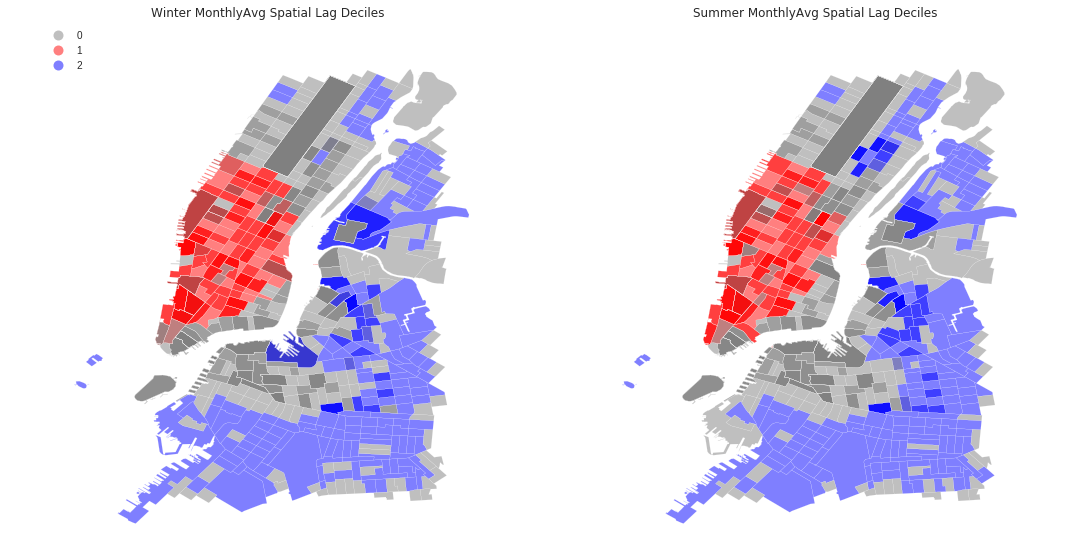

In [97]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
w_hotcold = w_hotspots*1 + w_coldspots*2
s_hotcold = s_hotspots*1 + s_coldspots*2
#if its true, it will be 1 * 1
#if its true, it will be 1 * 2
# if false, =0
# so either get 0, 1, 2

f, ax = plt.subplots(figsize=(18, 9))

ax1 = plt.subplot(121)
ct_shape_WinterAvg_Zoom.assign(cl=w_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Winter MonthlyAvg Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_SummerAvg_Zoom.assign(cl=s_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=False)
ax2.set_axis_off()
plt.title("Summer MonthlyAvg Spatial Lag Deciles")